<a href="https://colab.research.google.com/github/FatemeFarhang/data-science/blob/main/Task_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For more convenience, I switched my data to random tweets to include reply and like counts as well as retweet counts.

Alternative toy data set is included at the end of the notebook.

## Import data and inquiries

### Libraries

In [1]:
# DataFrame
import pandas as pd
pd.set_option("max_colwidth", 200)

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# # Scikit-learn
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# from sklearn.manifold import TSNE
# from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# from keras.models import Sequential
# from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
# from keras import utils
# from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import time
import pickle
from datetime import datetime, timedelta

### Import Data

In [202]:
url = "https://github.com/sraeisi/MachineLearning_Physics/blob/master/Data/random_tweets.csv?raw=true"
df = pd.read_csv(url,
                 usecols = [2,6,7,10,11,15,16,17]
                 )
df = df[df['language']=='en'].drop(['language'], axis=1)
df.drop_duplicates(ignore_index=True, inplace=True)
# df = df.sample(random_state=0, frac= .5, ignore_index = True)

print(f'There are a total number of {len(df)} tweets in this dataset.')
df.head()


There are a total number of 17513 tweets in this dataset.


,created_at,user_id,username,tweet,replies_count,retweets_count,likes_count
0,2021-10-02 23:59:59 UTC,1127431975520882688,maudi63,"@Timodc I just looked up where he grew up. Lowell, Massachusetts. I live near there now. My 3 kids all got their degrees the same place as him, UMass Lowell. There were lots of ‘tough towns’ in MA...",28,13,214
1,2021-10-02 23:59:58 UTC,793331593,tee_asz,Good morning to the ICAC commissioners in NSW who were doing the job they were tasked to do and enforcing the rule of law.,7,107,584
2,2021-10-02 23:59:58 UTC,386317180,swtlovex,U see some of us that can’t dance just like Whitemoney? U have no idea how we dance beautifully in our heads. The only problem is the execution in real steps,8,10,41
3,2021-10-02 23:59:56 UTC,1264612627516293121,kiergzn_,Thank you for all the killings and making the country more divided EVER in history. #SalamatPRRD,5,17,125
4,2021-10-02 23:59:56 UTC,265209421,mewiyev,the bookworm swordsman #Xingqiu #GenshinImapct https://t.co/OpVuz7rAG6,1,101,534


In [203]:
# convert time
df['created_at'] = [datetime.strptime(df.iloc[i]['created_at'], "%Y-%d-%m %H:%M:%S %Z") for i in range(len(df))]

# First Metric | Average Interactions per Post

In [204]:
users = df.user_id.unique()
n_posts = [len(df[df['user_id']== u]) for u in users]
df_user = pd.DataFrame({'id':users,
                             'n_posts': n_posts})

In [205]:
%%time
# average interactions per post
for i,r in df.iterrows():
    row = df.at[i, 'tweet']
    sub_df = df[df['tweet'] == row]
    n_int = 0
    if ( abs(sub_df['created_at'].diff()) ).sum() < timedelta(hours = 4): #only take into account the tweets that are created within approximately 4 hours
        n_int = n_int + np.sum(sub_df['likes_count'] + sub_df['retweets_count'] + sub_df['replies_count'])
        df.at[i,'avg_int'] = round(float( n_int / df_user.loc[df_user['id']==df.iloc[i]['user_id'], 'n_posts'] ),2)
    else:
        origin = df.index[(df['tweet']==row) & (df['created_at']==min(sub_df['created_at']))][0] #the original tweet index
        n_int = n_int + np.sum(df.iloc[origin]['likes_count'] + df.iloc[origin]['retweets_count'] + df.iloc[origin]['replies_count'])
        df.at[origin,'avg_int'] = round(float( n_int / df_user.loc[df_user['id']==df.iloc[i]['user_id'], 'n_posts'] ),2)


CPU times: user 1min 30s, sys: 766 ms, total: 1min 31s
Wall time: 1min 37s


In [206]:
df.head(5)

,created_at,user_id,username,tweet,replies_count,retweets_count,likes_count,avg_int
0,2021-02-10 23:59:59,1127431975520882688,maudi63,"@Timodc I just looked up where he grew up. Lowell, Massachusetts. I live near there now. My 3 kids all got their degrees the same place as him, UMass Lowell. There were lots of ‘tough towns’ in MA...",28,13,214,255.0
1,2021-02-10 23:59:58,793331593,tee_asz,Good morning to the ICAC commissioners in NSW who were doing the job they were tasked to do and enforcing the rule of law.,7,107,584,698.0
2,2021-02-10 23:59:58,386317180,swtlovex,U see some of us that can’t dance just like Whitemoney? U have no idea how we dance beautifully in our heads. The only problem is the execution in real steps,8,10,41,59.0
3,2021-02-10 23:59:56,1264612627516293121,kiergzn_,Thank you for all the killings and making the country more divided EVER in history. #SalamatPRRD,5,17,125,147.0
4,2021-02-10 23:59:56,265209421,mewiyev,the bookworm swordsman #Xingqiu #GenshinImapct https://t.co/OpVuz7rAG6,1,101,534,636.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3c116e9fd0>]],
      dtype=object)

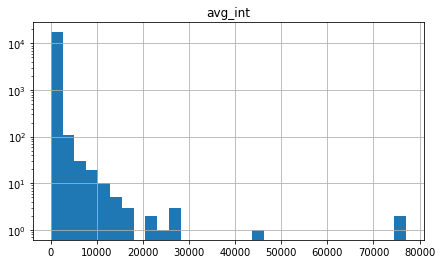

In [215]:
df.hist(['avg_int'],bins=30, log=True, figsize=(7,4))

# Second Metric | Passion Point

For this part we need to label positive and negative tweets. <br/>
Since _emojis_ are the most common seperators of negative and positive tweets, I will annotate the dataset mainly based on those in my first attempt.

In [ ]:
semantic_list = []
for i,r in df.iterrows():
    for word in df.at[i,'tweet'].lower().split(" "):
        # positive
        if word in[':)', ':p', ':d', ':-)', ':))', 'love', 'great', 'thanks', 'thank', 'happy', 'nice', 'good', 'love', 'awesome', '&lt;3', 'follow']:
            semantic_list.append(1)
        # negative
        elif word in[':(((', ':((', ':(', ':-(', 'sad', 'miss', 'sorry']:
            semantic_list.append(0)
        else:
            semantic_list.append(0)

print(f'Total number of tweets annonated as positive = {np.sum(semantic_list)}')

Total number of tweets annonated as positive = 2572


So, this annotation is likely to be biased since it considers only a few expressions. <br/>
Therefore I will use **transfer learning** to annotate tweets.

### Download saved model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive"
if os.path.isdir('~/.kaggle')==0:
    os.makedirs('~/.kaggle')
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

Mounted at /content/drive
cp: cannot create regular file '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
# download saved model
!kaggle kernels output paoloripamonti/twitter-sentiment-analysis

Output file downloaded to /content/encoder.pkl
Output file downloaded to /content/model.h5
Output file downloaded to /content/model.w2v
Output file downloaded to /content/tokenizer.pkl
Kernel log downloaded to /content/twitter-sentiment-analysis.log 


### Tokenize text

In order to use the saved model, I have to use the same tokenizer as the model was trained on. <br/>
The downside to this is that the model won't observe new words from my dataset. However the vocabulary is large enough to yield nice results.

In [ ]:
%%time
with open('tokenizer.pkl', 'rb') as tk:
    tokenizer = pickle.load(tk)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 653 ms, sys: 65.3 ms, total: 718 ms
Wall time: 706 ms


## Load model and predict

In [ ]:
model = keras.models.load_model('model.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 300)          87125700  
                                                                 
 dropout_1 (Dropout)         (None, 300, 300)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


### Predict

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = 'NEUTRAL'
        if score <= 0.4:
            label = 'NEGATIVE'
        elif score >= 0.6:
            label = 'POSITIVE'

        return label
    else:
        return 'NEGATIVE' if score < 0.5 else 'POSITIVE'

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=300)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [ ]:
%%time
for i,r in df.iterrows():
    df.at[i, 'semantic'] = predict(df.at[i, 'tweet'])['label']

CPU times: user 40min 29s, sys: 37.5 s, total: 41min 6s
Wall time: 28min 52s


In [ ]:
df.tail()

,created_at,user_id,username,tweet,replies_count,retweets_count,likes_count,n_posts,avg_int,semantic
17508,2021-02-10 23:52:51,1348203628910108681,_tannie5,"@dylanbehavior @chartdata @coldplay @BTS_twt Deserved!😍💜 Its such beautiful song, not just because the music and lyrics are incredible, but the message of love across boundaries and borders is so...",0,0,5,4.0,1,POSITIVE
17509,2021-02-10 23:52:51,418171272,thedano9er,"@spinnershells Can’t take credit, but love this idea. https://t.co/84j3Uu1471",2,1,36,1.0,39,POSITIVE
17510,2021-02-10 23:52:51,1378288666485747715,pinocchioplyric,"Now with a smile worn down by the sands of time, I'm well on pace for my wrinkle-filled finale.",0,3,2,1.0,5,POSITIVE
17511,2021-02-10 23:52:51,2777152740,leepavelich,@tszzl @gbrl_dick The 100 Trillion-Year Boomer Reich,1,1,9,1.0,11,NEUTRAL
17512,2021-02-10 23:52:51,923672752086757377,writtentherapy,waking early to watch the creation of another day - light being born #poetry #writing #storyin12 #creation,0,2,8,2.0,5,POSITIVE


In [ ]:
df.to_csv('drive/MyDrive/semantic_analysed_tweets.csv')

In [ ]:
# no. of positive posts of each user
df_user['n_positives'] = [len(df.loc[(df['user_id']== i) & (df['semantic'] == 'POSITIVE')]) for i in users]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc4dd79c310>]],
      dtype=object)

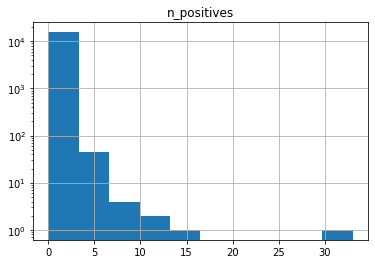

In [ ]:
df_user.hist(['n_positives'],log=True)

In [ ]:
# ranking of users
def rank_user(n_plus, n_post):
    z = 1.96 # for 95% confidence level
    r = n_plus/n_post
    return  float(( r + z**2/(2*n_post) ) / (1 + z**2/n_post) - z/ (1+ z**2/n_post)*np.sqrt(r*(1-r)/n_post + z**2/(4*n_post**2)) )

# passion point of users
def ppoint(n_plus, rank, n_day, n_post):
    return round(float( n_plus/n_day * (rank + np.log(n_post)) ),3)

In [ ]:
n_positive = df_user['n_positives'].values
n_post = df_user['n_posts'].values
df_user['rank'] = [rank_user( n_positive[u] , n_post[u] ) for u in range(len(users))]

n_day = [abs(df.loc[df['user_id'] == u, 'created_at'].diff()).sum().days for u in users]
print(f'since all time daltas are equal to {np.sum(n_day)} days, I will put n_day = 1 for all datapoints.')

rank = df_user['rank'].values
df_user['ppoint'] = [ppoint(n_positive[u], rank[u], 1, n_post[u]) for u in range(len(users))]

since all time daltas are equal to 0 days, I will put n_day = 1 for all datapoints.


In [ ]:
df_user.sort_values('ppoint', axis=0, ascending=False)

,id,n_posts,n_positives,rank,ppoint
106,1344497314052890625,39.0,33,7.027023e-01,144.087
815,986480658888511488,15.0,15,7.961107e-01,52.562
6191,1142549820797849601,12.0,12,7.574992e-01,38.909
6890,32779145,11.0,11,7.411600e-01,34.530
148,1917731,16.0,9,3.317820e-01,27.939
...,...,...,...,...,...
7645,3148707080,1.0,0,-5.551115e-17,-0.000
7646,1195552169946238978,1.0,0,-5.551115e-17,-0.000
7647,1017553698359271424,1.0,0,-5.551115e-17,-0.000
7648,44239034,1.0,0,-5.551115e-17,-0.000


# Third Metric | Content Creation

## Pre-Process dataset

In [ ]:
nltk.download('stopwords')
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
%%time
df_doc = df.tweet.apply(lambda x: preprocess(x))

CPU times: user 1.65 s, sys: 21.9 ms, total: 1.67 s
Wall time: 1.72 s


In [ ]:
%%time
documents = [_text for _text in df_doc] 

CPU times: user 6.46 ms, sys: 0 ns, total: 6.46 ms
Wall time: 6.46 ms


In order to find the number of positive words in tweets, it's helpful to find the word similarities in tweets.



In [ ]:
#load the model
w2v_model = gensim.models.word2vec.Word2Vec.load("model.w2v")
w2v_model.build_vocab(documents, update=True)
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size =", vocab_size)

Vocab size = 30577


### Word2Vec

In [ ]:
# train the model
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=32)

CPU times: user 36.3 s, sys: 227 ms, total: 36.5 s
Wall time: 19.4 s


(6141736, 7290752)

In [ ]:
suggest = ['love','happy', 'best', 'nice', 'thank', 'great', 'cheers','top','hi', 'follow','beautiful']
words_scores = w2v_model.wv.most_similar(suggest, topn=300)
positive_vocab =[]
for i, w1 in enumerate(words_scores):
    positive_vocab.append(w1[0])
positive_vocab = np.concatenate((suggest, positive_vocab))

In [ ]:
def n_pos_word(string_list, vocab):
    w_pos= 0
    for w in string_list:
        if w in vocab:
            w_pos += 1
    return w_pos

In [ ]:
%%time
df['n_pos_words'] = df_doc.apply(lambda x: n_pos_word(x,positive_vocab))
df['n_words'] = [len(df_doc[i]) for i in range(len(df_doc))]

CPU times: user 2.95 s, sys: 15.6 ms, total: 2.97 s
Wall time: 4.02 s


In [ ]:
%%time
df_user['avg_words'] = [(np.sum(df.loc[df['user_id']== users[i], 'n_words'].values)/n_post[i]) for i in range(len(users))]

CPU times: user 9.92 s, sys: 36.5 ms, total: 9.96 s
Wall time: 22.6 s


In [ ]:
for i in range(len(users)):
    w = df_user.at[i,'avg_words']
    sub_df2 = df[df['n_words']>w]
    quality = np.sum(sub_df2['n_pos_words'].values/sub_df2['n_words'].values)/len(sub_df2)
    df_user.at[i,'quality'] = quality
    df_user.at[i, 'content_score'] = np.log(quality) + df_user.at[i, 'ppoint']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [ ]:
df_user.sort_values('content_score', ascending=False)

,id,n_posts,n_positives,rank,ppoint,avg_words,quality,content_score
106,1344497314052890625,39.0,33,7.027023e-01,144.087,4.564103,0.031130,140.617430
815,986480658888511488,15.0,15,7.961107e-01,52.562,9.466667,0.028858,49.016638
6191,1142549820797849601,12.0,12,7.574992e-01,38.909,19.250000,0.025599,35.243793
6890,32779145,11.0,11,7.411600e-01,34.530,16.181818,0.026616,30.903761
148,1917731,16.0,9,3.317820e-01,27.939,10.562500,0.028575,24.383790
...,...,...,...,...,...,...,...,...
11354,111332093,1.0,0,-5.551115e-17,-0.000,46.000000,0.008182,-4.805859
15162,247081633,1.0,0,-5.551115e-17,-0.000,57.000000,0.008013,-4.826688
11356,1441178543723986945,1.0,0,-5.551115e-17,-0.000,62.000000,0.007885,-4.842806
8922,243301984,1.0,0,-5.551115e-17,-0.000,60.000000,0.007168,-4.938117


# Toy data set analysis

In [113]:
pip install randomtimestamp

In [285]:
from randomtimestamp import randomtimestamp
created_at = [randomtimestamp(start= datetime(2021, 12, 5, 11, 20, 10), end= datetime(2021, 12, 8, 11, 20, 10), pattern="%Y-%d-%m %H:%M:%S %Z") for i in range(10000)]

# generating random data
user_id = np.random.normal(18401399840984, scale= np.random.randint(800,3000,size= 10000), size= 10000).astype(int)
replies_count = abs(np.random.normal(0, scale= np.random.randint(1,30,size= 10000), size= 10000).astype(int))
retweets_count = abs(np.random.normal(0, scale= np.random.randint(1,20,size= 10000), size= 10000).astype(int))
likes_count = abs(np.random.normal(0,30, size= 10000).astype(int))
n_positive_words = abs(np.random.normal(0, scale= np.random.randint(1,5,size= 10000), size= 10000).astype(int))
n_words = abs(np.random.normal(20, scale= np.random.randint(1,5,size= 10000), size= 10000).astype(int))
semantic = np.random.choice(['POSITIVE', 'NEGATIVE', 'NEUTRAL'], 10000)

# create data frame of the random data
df_toy = pd.DataFrame(
                    np.array([user_id,replies_count, retweets_count, likes_count, n_positive_words, n_words]).T,
                    columns = ['user_id','replies_count', 'retweets_count', 'likes_count', 'n_positive_words', 'n_words'],
                    dtype=int
                    )
df_toy['semantic'] = semantic
df_toy.insert(0, 'created_at', created_at)

In [286]:
df_toy.head()

,created_at,user_id,replies_count,retweets_count,likes_count,n_positive_words,n_words,semantic
0,2021-12-05 14:44:22,18401399837088,8,11,10,3,18,POSITIVE
1,2021-12-08 03:03:57,18401399844881,3,27,39,2,18,POSITIVE
2,2021-12-05 23:04:44,18401399842168,13,29,33,10,15,POSITIVE
3,2021-12-06 16:57:22,18401399843909,14,7,2,0,16,NEUTRAL
4,2021-12-05 14:33:50,18401399842316,4,16,80,0,21,NEGATIVE


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3c0cb0c0d0>,
      dtype=object)

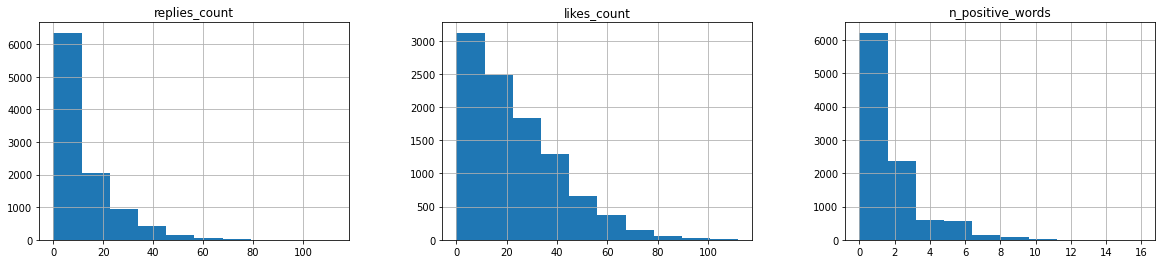

In [287]:
df_toy.hist(['replies_count','likes_count','n_positive_words'],figsize=(20,4),layout=(1,3))

### First Metric | Average Interactions per Post

In [288]:
%%time
users_toy = df_toy.user_id.unique()
n_posts_toy = [len(df_toy[df_toy['user_id']== u]) for u in users_toy]
df_toy_users = pd.DataFrame({'id':users_toy,
                             'n_posts': n_posts_toy})

for i,r in df_toy.iterrows():
    sub_df = df_toy.loc[df_toy['user_id']== df_toy.at[i,'user_id']]
    if ( abs(sub_df['created_at'].diff()) ).sum() < timedelta(hours = 4): #only take into account the tweets that are created within approximately 4 hours
        n_int = 0
        n_int = n_int + np.sum(sub_df['likes_count'] + sub_df['retweets_count'] + sub_df['replies_count'])
        df_toy.at[i,'avg_int'] = round(float(n_int / df_toy_users.loc[df_toy_users['id']==df_toy.iloc[i]['user_id'] , 'n_posts']),2)
    else:
        n_int = 0
        n_int = n_int + np.sum(df_toy.at[i,'likes_count'] + df_toy.at[i,'retweets_count'] + df_toy.at[i,'replies_count'])
        df_toy.at[i, 'avg_int'] = round(float(n_int / df_toy_users.loc[df_toy_users['id']==df_toy.iloc[i]['user_id'] , 'n_posts'] ),2)

CPU times: user 21 s, sys: 453 ms, total: 21.5 s
Wall time: 21 s


In [289]:
df_toy.head(5)

,created_at,user_id,replies_count,retweets_count,likes_count,n_positive_words,n_words,semantic,avg_int
0,2021-12-05 14:44:22,18401399837088,8,11,10,3,18,POSITIVE,29.0
1,2021-12-08 03:03:57,18401399844881,3,27,39,2,18,POSITIVE,69.0
2,2021-12-05 23:04:44,18401399842168,13,29,33,10,15,POSITIVE,25.0
3,2021-12-06 16:57:22,18401399843909,14,7,2,0,16,NEUTRAL,23.0
4,2021-12-05 14:33:50,18401399842316,4,16,80,0,21,NEGATIVE,25.0


### Second Metric | Passion Point

In [290]:
# no. of positive posts of each user
df_toy_users['n_positives'] = [len(df_toy.loc[(df_toy['user_id']== i) & (df_toy['semantic'] == 'POSITIVE')]) for i in users_toy]

In [270]:
# ranking of users
def rank_user(n_plus, n_post):
    z = 1.96 # for 95% confidence level
    r = n_plus/n_post
    return  float(( r + z**2/(2*n_post) ) / (1 + z**2/n_post) - z/ (1+ z**2/n_post)*np.sqrt(r*(1-r)/n_post + z**2/(4*n_post**2)) )

# passion point of users
def ppoint(n_plus, rank,n_day, n_post):
    return round(float( n_plus* (rank + np.log(n_post))/ n_day  ),3)

In [291]:
n_positive = df_toy_users['n_positives'].values
df_toy_users['rank'] = [rank_user( n_positive[u] , n_posts_toy[u] ) for u in range(len(users_toy))]

n_day = np.array([abs(df_toy.loc[df_toy['user_id'] == u, 'created_at'].diff()).sum().days for u in users_toy])
n_day[n_day==0] = 1

rank = df_toy_users['rank'].values
df_toy_users['ppoint'] = [ppoint(n_positive[u], rank[u], n_day[u], n_posts_toy[u]) for u in range(len(users_toy))]

In [292]:
df_toy_users

,id,n_posts,n_positives,rank,ppoint
0,18401399837088,1,1,2.065433e-01,0.207
1,18401399844881,1,1,2.065433e-01,0.207
2,18401399842168,3,2,2.076550e-01,2.613
3,18401399843909,1,0,-5.551115e-17,-0.000
4,18401399842316,4,0,0.000000e+00,0.000
...,...,...,...,...,...
5376,18401399843510,1,0,-5.551115e-17,-0.000
5377,18401399842705,1,1,2.065433e-01,0.207
5378,18401399838954,1,1,2.065433e-01,0.207
5379,18401399838122,1,1,2.065433e-01,0.207


### Third Metric | Content Creation

In [293]:
df_toy_users['avg_words'] = [round(np.sum(df_toy[df_toy['user_id']==users_toy[u]]['n_words'])/n_posts_toy[u],2) for u in range(len(users_toy))]

In [294]:
for i in range(len(users_toy)):
    w = df_toy_users.at[i,'avg_words']
    sub_df2 = df_toy[df_toy['n_words']>w]
    quality = np.sum(sub_df2['n_positive_words'].values/sub_df2['n_words'].values)/len(sub_df2)
    df_toy_users.at[i,'quality'] = quality
    df_toy_users.at[i, 'content_score'] = np.log(quality) + df_toy_users.at[i, 'ppoint']

In [295]:
df_toy_users.sort_values('content_score', ascending=False)

,id,n_posts,n_positives,rank,ppoint,avg_words,quality,content_score
2015,18401399841620,4,4,5.101000e-01,7.586,20.25,0.069045,4.913008
776,18401399840007,6,6,6.096570e-01,7.204,18.67,0.074436,4.606188
1829,18401399840096,5,3,2.307199e-01,5.520,18.80,0.074436,2.922188
794,18401399840665,5,3,2.307199e-01,5.520,19.40,0.072211,2.891836
1995,18401399841051,5,3,2.307199e-01,5.520,20.20,0.069045,2.847008
...,...,...,...,...,...,...,...,...
3353,18401399840374,1,0,-5.551115e-17,-0.000,29.00,0.042988,-3.146832
5059,18401399843051,1,0,-5.551115e-17,-0.000,29.00,0.042988,-3.146832
3322,18401399844854,1,0,-5.551115e-17,-0.000,29.00,0.042988,-3.146832
4886,18401399839406,1,0,-5.551115e-17,-0.000,29.00,0.042988,-3.146832
